# Session 11 - CAMs, LRs, and Optimizers

This assignment is based on - https://github.com/kuangliu/pytorch-cifar

In [ ]:
! git clone https://github.com/divyamarora910/deep-learning-school-of-ai.git

fatal: destination path 'deep-learning-school-of-ai' already exists and is not an empty directory.


In [ ]:
%ls

data/  deep-learning-school-of-ai/  sample_data/


In [ ]:
from __future__ import print_function
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
!pip install torch-lr-finder
!pip install torchsummary
!pip install albumentations

In [ ]:
from torchsummary import summary

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([

                                       transforms.ToTensor(),
                                       transforms.Normalize(\
                                          (0.4914, 0.4822, 0.4465), \
                                          (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([

                                       transforms.ToTensor(),
                                       transforms.Normalize(\
                                          (0.4914, 0.4822, 0.4465), \
                                          (0.2023, 0.1994, 0.2010))
                                       ])


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
        A.RandomCrop(height=32, width=32, always_apply=True),
        A.HorizontalFlip(),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=means),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        ToTensorV2(),
    ]
)

In [ ]:
class Cifar10SearchDataset(datasets.CIFAR10):

    def __init__(self, root="~/data", train=True, download=True, transform=None):

        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):

        image, label = self.data[index], self.targets[index]

        if self.transform is not None:

            transformed = self.transform(image=image)

            image = transformed["image"]

        return image, label

In [ ]:
train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


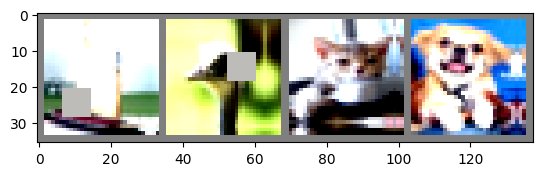

ship  bird  cat   dog  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, scheduler, criterion):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader,criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.93E-02


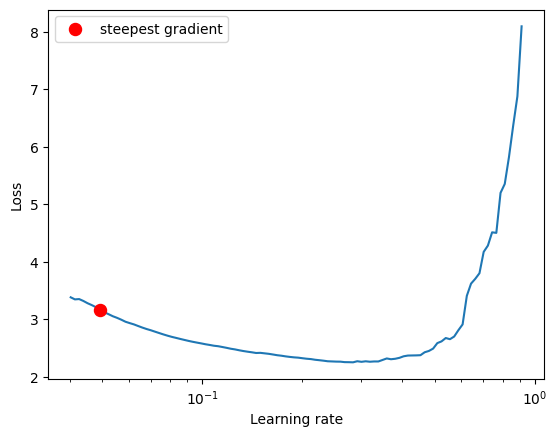

In [ ]:
from torch_lr_finder import LRFinder

model = ResNet18().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 20

scheduler = OneCycleLR(
        optimizer,
        max_lr=5.07E-02,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )



In [ ]:
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler, criterion)
    test(model, device, test_loader, criterion)

EPOCH: 0


Loss=1.3980563879013062 Batch_id=97 Accuracy=44.93: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]



Test set: Average loss: 0.0047, Accuracy: 3577/10000 (35.77%)

EPOCH: 1


Loss=1.135697364807129 Batch_id=97 Accuracy=55.82: 100%|██████████| 98/98 [00:50<00:00,  1.93it/s]



Test set: Average loss: 0.0024, Accuracy: 5628/10000 (56.28%)

EPOCH: 2


Loss=1.0561562776565552 Batch_id=97 Accuracy=60.99: 100%|██████████| 98/98 [00:51<00:00,  1.89it/s]



Test set: Average loss: 0.0022, Accuracy: 6062/10000 (60.62%)

EPOCH: 3


Loss=0.9414963722229004 Batch_id=97 Accuracy=64.52: 100%|██████████| 98/98 [00:50<00:00,  1.93it/s]



Test set: Average loss: 0.0035, Accuracy: 3853/10000 (38.53%)

EPOCH: 4


Loss=1.016463041305542 Batch_id=97 Accuracy=65.27: 100%|██████████| 98/98 [00:50<00:00,  1.94it/s]



Test set: Average loss: 0.0028, Accuracy: 5373/10000 (53.73%)

EPOCH: 5


Loss=0.8387879133224487 Batch_id=97 Accuracy=66.79: 100%|██████████| 98/98 [00:50<00:00,  1.94it/s]



Test set: Average loss: 0.0034, Accuracy: 4904/10000 (49.04%)

EPOCH: 6


Loss=0.7759280204772949 Batch_id=97 Accuracy=68.80: 100%|██████████| 98/98 [00:49<00:00,  1.97it/s]



Test set: Average loss: 0.0041, Accuracy: 4948/10000 (49.48%)

EPOCH: 7


Loss=0.8560072779655457 Batch_id=97 Accuracy=70.29: 100%|██████████| 98/98 [00:49<00:00,  1.98it/s]



Test set: Average loss: 0.0030, Accuracy: 5250/10000 (52.50%)

EPOCH: 8


Loss=0.7207404375076294 Batch_id=97 Accuracy=71.75: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s]



Test set: Average loss: 0.0019, Accuracy: 6699/10000 (66.99%)

EPOCH: 9


Loss=0.7631794214248657 Batch_id=97 Accuracy=72.65: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s]



Test set: Average loss: 0.0019, Accuracy: 6779/10000 (67.79%)

EPOCH: 10


Loss=0.7975888252258301 Batch_id=97 Accuracy=73.92: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s]



Test set: Average loss: 0.0020, Accuracy: 6668/10000 (66.68%)

EPOCH: 11


Loss=0.6589188575744629 Batch_id=97 Accuracy=75.32: 100%|██████████| 98/98 [00:49<00:00,  1.97it/s]



Test set: Average loss: 0.0041, Accuracy: 4858/10000 (48.58%)

EPOCH: 12


Loss=0.6984919309616089 Batch_id=97 Accuracy=76.50: 100%|██████████| 98/98 [00:49<00:00,  1.98it/s]



Test set: Average loss: 0.0018, Accuracy: 6906/10000 (69.06%)

EPOCH: 13


Loss=0.6124533414840698 Batch_id=97 Accuracy=77.44: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s]



Test set: Average loss: 0.0017, Accuracy: 7144/10000 (71.44%)

EPOCH: 14


Loss=0.6359635591506958 Batch_id=97 Accuracy=78.57: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s]



Test set: Average loss: 0.0016, Accuracy: 7442/10000 (74.42%)

EPOCH: 15


Loss=0.573235034942627 Batch_id=97 Accuracy=80.19: 100%|██████████| 98/98 [00:48<00:00,  2.00it/s]



Test set: Average loss: 0.0013, Accuracy: 7857/10000 (78.57%)

EPOCH: 16


Loss=0.5581116676330566 Batch_id=97 Accuracy=81.46: 100%|██████████| 98/98 [00:48<00:00,  2.02it/s]



Test set: Average loss: 0.0015, Accuracy: 7565/10000 (75.65%)

EPOCH: 17


Loss=0.41637152433395386 Batch_id=97 Accuracy=83.42: 100%|██████████| 98/98 [00:48<00:00,  2.03it/s]



Test set: Average loss: 0.0010, Accuracy: 8335/10000 (83.35%)

EPOCH: 18


Loss=0.3614906668663025 Batch_id=97 Accuracy=85.58: 100%|██████████| 98/98 [00:48<00:00,  2.04it/s]



Test set: Average loss: 0.0009, Accuracy: 8518/10000 (85.18%)

EPOCH: 19


Loss=0.3247568905353546 Batch_id=97 Accuracy=87.67: 100%|██████████| 98/98 [00:47<00:00,  2.04it/s]



Test set: Average loss: 0.0007, Accuracy: 8809/10000 (88.09%)



In [ ]:
number_of_misclassified_images = 0
with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=False)
            pred,target = pred.cpu(),target.cpu()
            #print(pred,target)
            misclassified_images_args = np.argwhere(pred!=target).flatten()
            number_of_misclassified_images = misclassified_images_args.shape[0]
            data = data.cpu()[misclassified_images_args]
            print(data.shape)
            if number_of_misclassified_images>10:
                break


torch.Size([53, 3, 32, 32])


In [ ]:
data,target,pred = data[:11,:,:,:],target[:11],pred[:11]

In [ ]:
data.shape,target.shape,pred.shape

(torch.Size([11, 3, 32, 32]), torch.Size([11]), torch.Size([11]))

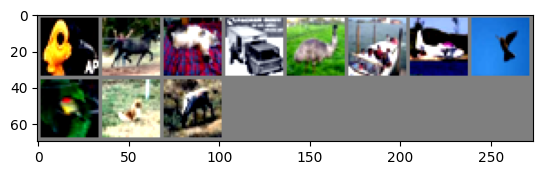

In [ ]:
imshow(torchvision.utils.make_grid(data))

In [ ]:
! pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=bee295cca7da1a099f3332a4911ab60c55e43b40508f0a6593000415c1723998
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [ ]:
model.layer3[-1]

BasicBlock(
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential()
)

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
target_layers = [model.layer4[-1]]
input_tensor = data# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

In [ ]:
model(input_tensor.to(device)).shape

torch.Size([11, 10])

In [ ]:
input_tensor.shape

torch.Size([11, 3, 32, 32])

In [ ]:
np.max(np.float32(input_tensor[0,:].reshape([32, 32,3]))/255)

0.008074938

In [ ]:
grayscale_cam = cam(input_tensor=input_tensor[0:1,:].to(device),)

# In this example grayscale_cam has only one image in the batch:
print(grayscale_cam.shape)
grayscale_cam = grayscale_cam[0, :]
print(grayscale_cam.shape)
visualization = show_cam_on_image(np.float32(input_tensor[0,:].reshape([32, 32,3]))/255, grayscale_cam, use_rgb=True)

(1, 32, 32)
(32, 32)


In [ ]:
visualization.shape

(32, 32, 3)

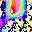

In [ ]:
from PIL import Image
Image.fromarray(visualization)

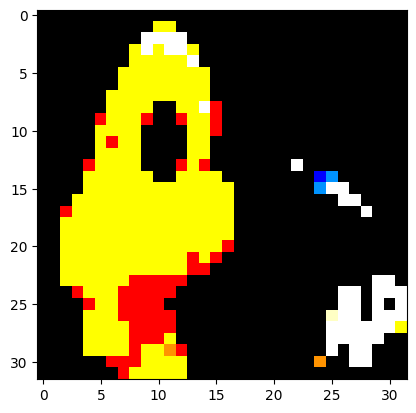

(None, tensor(5))

In [ ]:
imshow(torchvision.utils.make_grid(input_tensor[0:1,:])*255),target[0]

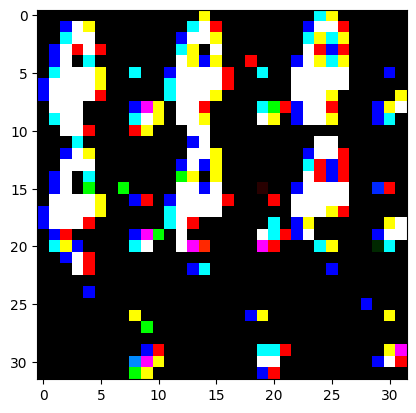

In [ ]:
plt.imshow(input_tensor[0:1,:].reshape([32, 32,3])*255)

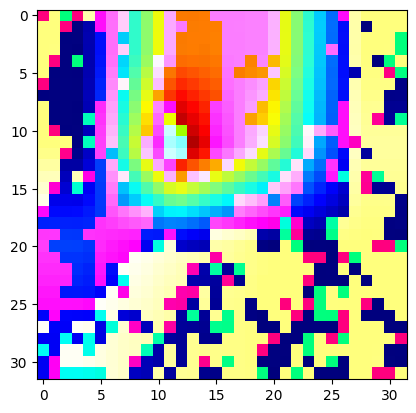

In [ ]:
plt.imshow(visualization)

In [ ]:
target_layers = [model.layer4[-1]]
input_tensor = data# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

In [ ]:
#for index in range(11):
grayscale_cam = cam(input_tensor=input_tensor.to(device),)

# In this example grayscale_cam has only one image in the batch:
#print(grayscale_cam.shape)
#grayscale_cam = grayscale_cam[0, :]
#print(grayscale_cam.shape)
vl = []
for index in range(10):
    visualization = show_cam_on_image(np.float32(input_tensor[index,:].reshape([32, 32,3]))/255, \
                                  grayscale_cam[index, :], use_rgb=True)
    vl.append(visualization)

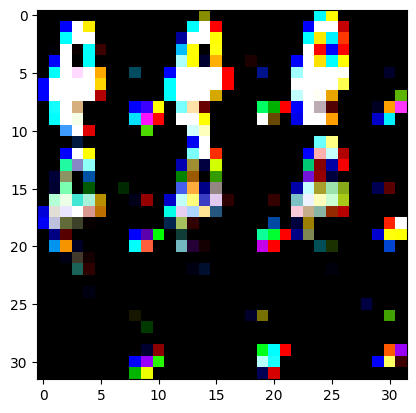

In [ ]:
plt.imshow(input_tensor[0,:].reshape([32, 32,3]))

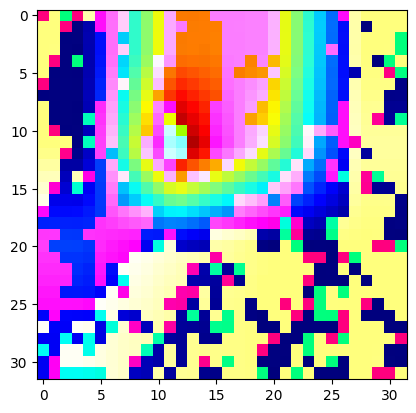

In [ ]:
plt.imshow(vl[0])

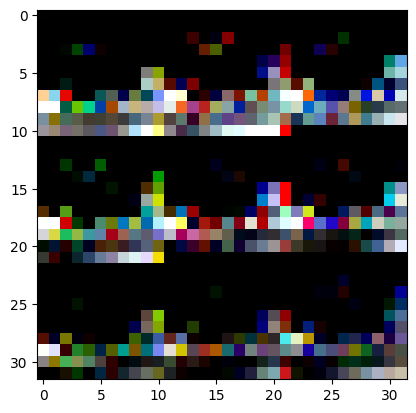

In [ ]:
plt.imshow(input_tensor[1,:].reshape([32, 32,3]))

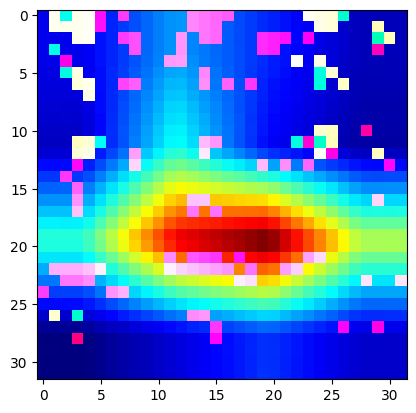

In [ ]:
plt.imshow(vl[1])

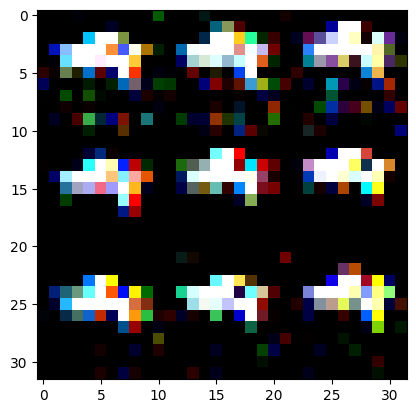

In [ ]:
plt.imshow(input_tensor[2,:].reshape([32, 32,3]))

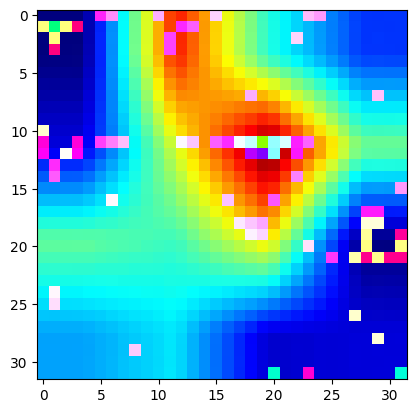

In [ ]:
plt.imshow(vl[2])

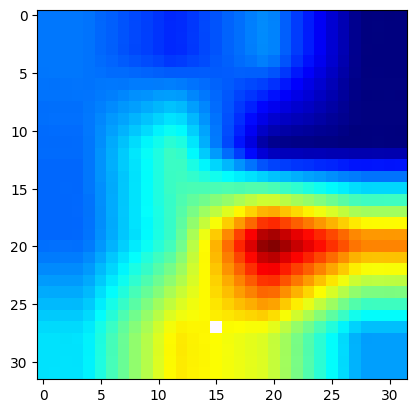

In [ ]:
for i in vl:
    plt.imshow(i)